# Predicting Service Disruptions

## Loading Data
***

In [1]:
import pandas as pd
EventTypeData = pd.read_csv("event_type.csv")
LogFeatureData = pd.read_csv("log_feature.csv")
ResourceTypeData = pd.read_csv("resource_type.csv")
SeverityTypeData = pd.read_csv("severity_type.csv")
FaultData = pd.read_csv("train.csv")

print("Event Type")
print(EventTypeData.head(3))
print("")
print("Log-Feature")
print(LogFeatureData.head(3))
print("")
print("Resource Type")
print(ResourceTypeData.head(3))
print("")
print("Severity Type")
print(SeverityTypeData.head(3))
print("")
print("training")
print(FaultData.head(3))

Event Type
     id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15

Log-Feature
     id log_feature  volume
0  6597  feature 68       6
1  8011  feature 68       7
2  2597  feature 68       1

Resource Type
     id    resource_type
0  6597  resource_type 8
1  8011  resource_type 8
2  2597  resource_type 8

Severity Type
     id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2

training
      id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1


## Combine Datasets

### Find common data to merge on

* Event Type Data

    id: identifies a unique location-time point  
    event_type: type of event that ocurred at that ID (can be multiple events per ID)  

In [2]:
EventTypeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
id            31170 non-null int64
event_type    31170 non-null object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [3]:
EventTypeData.duplicated().sum()

0

In [4]:
EventTypeData["id"].duplicated().sum() # Note: event_type is inherently not unique

12618

> ### Note:
    > Rate or number of events likely an important predictor.

***
* Log Feature Data

    id : identifies a unique location-time point  
    log_feature: type of feature logged for that ID  
    volume: number of times the feature was logged for that ID  
***

In [5]:
LogFeatureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
id             58671 non-null int64
log_feature    58671 non-null object
volume         58671 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [6]:
LogFeatureData.duplicated().sum()

0

In [7]:
LogFeatureData[["id", "log_feature"]].duplicated().sum() # Note: volume is just a counter number

0

In [8]:
LogFeatureData["id"].duplicated().sum() # Note: log_feature is inherently not unique

40119

* Resource Type Data  

    id: identifies a unique location-time point  
    resource_type: type of resource associated with that ID  

In [9]:
ResourceTypeData.duplicated().sum()

0

In [10]:
ResourceTypeData["id"].duplicated().sum() # Note: resource_type is inherently not unique

2524

* Severity Type Data

    id: Identifies a unique location-time point  
    severity_type: type of severity level logged for that ID

In [11]:
SeverityTypeData.duplicated().sum()

0

In [12]:
SeverityTypeData["id"].duplicated().sum() # Note: severity_type is inherently not unique

0

* Training Data
        
    id :                identifies a unique location-time point.  
    location :          identifier of location  
    fault_severity :    categorical  
                        0 : no fault  
                        1 : a few faults  
                        2 : many faults  

In [13]:
FaultData.duplicated().sum()

0

In [14]:
FaultData[["id", "fault_severity"]].duplicated().sum(), FaultData[["id", "location"]].duplicated().sum(), FaultData[["location", "fault_severity"]].duplicated().sum()

(0, 0, 5859)

In [15]:
FaultData["id"].duplicated().sum(), FaultData["location"].duplicated().sum(), FaultData["fault_severity"].duplicated().sum()

(0, 6452, 7378)

#### Notes
    None of the datasets contain duplicated row entries.  
    However, each id may be associated with multiple events and each event may, each location may have multiple resources.  
    
    Exercise is essentially correlating "location" with "fault_severity"

    "id" contains both location and time data. 

### Merge data tables with unique "id" rows

In [16]:
FaultData["fault_severity"]

0       1
1       0
2       1
3       1
4       0
       ..
7376    0
7377    0
7378    2
7379    0
7380    0
Name: fault_severity, Length: 7381, dtype: int64

In [17]:
UniqueData = pd.DataFrame(columns = ["id"])
UniqueData["id"] = pd.Series(range(
    min(EventTypeData["id"].min(), LogFeatureData["id"].min(), ResourceTypeData["id"].min(), SeverityTypeData["id"].min(), FaultData["id"].min()), 
    max(EventTypeData["id"].max(), LogFeatureData["id"].max(), ResourceTypeData["id"].max(), SeverityTypeData["id"].max(), FaultData["id"].max()) + 1))
UniqueData.describe()

,id
count,18552.000000
mean,9276.500000
std,5355.645433
min,1.000000
25%,4638.750000
50%,9276.500000
75%,13914.250000
max,18552.000000


In [18]:
UniqueData = UniqueData.merge(FaultData, how="left", on="id")

In [19]:
UniqueData = UniqueData.merge(SeverityTypeData, how="left", on="id")

In [20]:
UniqueData

,id,location,fault_severity,severity_type
0,1,location 601,1.0,severity_type 1
1,2,NaN,NaN,severity_type 2
2,3,NaN,NaN,severity_type 1
3,4,NaN,NaN,severity_type 4
4,5,location 460,0.0,severity_type 2
...,...,...,...,...
18547,18548,location 278,0.0,severity_type 2
18548,18549,NaN,NaN,severity_type 1
18549,18550,location 12,0.0,severity_type 1
18550,18551,NaN,NaN,severity_type 1


### Merging data tables with duplicated "id" rows

In [21]:
KnownData = UniqueData

#### Event and Event Type

In [22]:
# Removing the text prefix to avoid excessively long category labels
EventTypeData["event_type"] = EventTypeData["event_type"].str.extract(r"(\d+)")

In [23]:
EventTypeData = pd.get_dummies(EventTypeData, drop_first = True)

In [24]:
EventTypeData = EventTypeData.groupby(["id"], as_index = False, sort = False).sum()

In [25]:
KnownData = KnownData.merge(EventTypeData, how = "left", on = "id")
KnownData

,id,location,fault_severity,severity_type,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,...,event_type_5,event_type_50,event_type_51,event_type_52,event_type_53,event_type_54,event_type_6,event_type_7,event_type_8,event_type_9
0,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,NaN,NaN,severity_type 4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,location 460,0.0,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18547,18548,location 278,0.0,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18548,18549,NaN,NaN,severity_type 1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18549,18550,location 12,0.0,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18550,18551,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
KnownData.describe()

,id,fault_severity,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,...,event_type_5,event_type_50,event_type_51,event_type_52,event_type_53,event_type_54,event_type_6,event_type_7,event_type_8,event_type_9
count,18552.000000,7381.00000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,...,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000
mean,9276.500000,0.45021,0.007816,0.425183,0.000323,0.031371,0.017788,0.236902,0.000162,0.003935,...,0.001401,0.008301,0.000216,0.000054,0.000916,0.036869,0.001509,0.001294,0.001563,0.000755
std,5355.645433,0.66656,0.088064,0.494384,0.017981,0.174324,0.132183,0.425193,0.012716,0.062607,...,0.037411,0.090733,0.014682,0.007342,0.030258,0.188446,0.038821,0.035945,0.039507,0.027461
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4638.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9276.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13914.250000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18552.000000,2.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Log Feature Data

In [27]:
LogFeatureData

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1
...,...,...,...
58666,8720,feature 209,1
58667,6488,feature 54,3
58668,878,feature 62,1
58669,4464,feature 209,1


In [28]:
LogFeatureData["log_feature"] = LogFeatureData["log_feature"].apply(lambda x: "log_" + x)
LogData = pd.get_dummies(LogFeatureData["log_feature"])
LogData.values[LogData != 0] = LogFeatureData["volume"]

In [29]:
LogData["id"] = LogFeatureData["id"]

In [30]:
LogData

,log_feature 1,log_feature 10,log_feature 100,log_feature 101,log_feature 102,log_feature 103,log_feature 104,log_feature 105,log_feature 106,log_feature 107,...,log_feature 91,log_feature 92,log_feature 93,log_feature 94,log_feature 95,log_feature 96,log_feature 97,log_feature 98,log_feature 99,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6597
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8011
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2597
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5022
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8720
58667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6488
58668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,878
58669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4464


In [31]:
KnownData = KnownData.merge(LogData, how = "left", on = "id")
KnownData

,id,location,fault_severity,severity_type,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,...,log_feature 90,log_feature 91,log_feature 92,log_feature 93,log_feature 94,log_feature 95,log_feature 96,log_feature 97,log_feature 98,log_feature 99
0,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58666,18550,location 12,0.0,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58667,18551,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58668,18551,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58669,18552,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Resource Type 

In [32]:
ResourceTypeData

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8
...,...,...
21071,3761,resource_type 8
21072,8720,resource_type 8
21073,6488,resource_type 8
21074,878,resource_type 8


In [33]:
# Removing the text prefix to avoid excessively long category labels
ResourceTypeData["resource_type"] = ResourceTypeData["resource_type"].str.extract(r"(\d+)")

In [34]:
ResourceTypeData = pd.get_dummies(ResourceTypeData, drop_first = True)

In [35]:
ResourceTypeData = ResourceTypeData.groupby(["id"], as_index = False, sort = False).sum()

In [36]:
KnownData = KnownData.merge(ResourceTypeData, how = "left", on = "id")
KnownData

,id,location,fault_severity,severity_type,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,...,log_feature 99,resource_type_10,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9
0,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,location 601,1.0,severity_type 1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58666,18550,location 12,0.0,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58667,18551,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58668,18551,NaN,NaN,severity_type 1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58669,18552,NaN,NaN,severity_type 2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Extract training data

>Aggregate known data into per-location rows

In [37]:
EventLogResourceData = KnownData.drop(["location", "fault_severity", "severity_type"], axis = 1)

In [38]:
EventLogResourceData

,id,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,event_type_19,...,log_feature 99,resource_type_10,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9
0,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58666,18550,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58667,18551,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58668,18551,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58669,18552,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
EventLogResourceData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58671 entries, 0 to 58670
Columns: 448 entries, id to resource_type_9
dtypes: int64(1), uint8(447)
memory usage: 25.9 MB


In [40]:
EventLogResourceData.isnull().sum().sum()

0

In [41]:
EventLogResourceData = EventLogResourceData.groupby("id").agg(sum).astype("uint8")

In [42]:
EventLogResourceData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 1 to 18552
Columns: 447 entries, event_type_10 to resource_type_9
dtypes: uint8(447)
memory usage: 8.1 MB


In [43]:
FaultLocationData = KnownData[["id", "fault_severity", "severity_type"]]
FaultLocationData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58671 entries, 0 to 58670
Data columns (total 3 columns):
id                58671 non-null int64
fault_severity    23851 non-null float64
severity_type     58671 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [44]:
FaultLocationData.isnull().sum()

id                    0
fault_severity    34820
severity_type         0
dtype: int64

In [45]:
#FaultLocationData["severity_type"] = FaultLocationData["severity_type"].str.extract(r"(\d+)", expand = False).astype("int8")
FaultLocationData = pd.get_dummies(FaultLocationData, drop_first = True)

In [46]:
FaultLocationData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58671 entries, 0 to 58670
Data columns (total 6 columns):
id                               58671 non-null int64
fault_severity                   23851 non-null float64
severity_type_severity_type 2    58671 non-null uint8
severity_type_severity_type 3    58671 non-null uint8
severity_type_severity_type 4    58671 non-null uint8
severity_type_severity_type 5    58671 non-null uint8
dtypes: float64(1), int64(1), uint8(4)
memory usage: 1.6 MB


In [47]:
TrainingData = FaultLocationData.groupby("id").agg(max)
TrainingData = TrainingData.merge(EventLogResourceData, how = "left", on = "id")
TrainingData

,fault_severity,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,...,log_feature 99,resource_type_10,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0,0,0,0,0,3,0,3,0,...,0,0,0,0,0,0,3,0,3,0
2,NaN,1,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
3,NaN,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,NaN,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0.0,1,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18548,0.0,1,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
18549,NaN,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
18550,0.0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [48]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 1 to 18552
Columns: 452 entries, fault_severity to resource_type_9
dtypes: float64(1), uint8(451)
memory usage: 8.3 MB


### Shallow Cleaning

In [49]:
def ShowSimpleScatter(DataSeries, width = 5, height = 5):
    import matplotlib.pyplot as plotter
    %matplotlib inline

    plotter.close("all")
    axes = plotter.figure(figsize = (width, height)).add_subplot(111)  # RowsColumnsIndex
                                                        # Index starts upper left corner
    x_data = list(range(len(DataSeries)))
    axes.scatter(x_data, DataSeries, s = 1, edgecolors = None)
    plotter.show()

In [50]:
def ShowSimpleHist(Data_List, width = 7, height = 7):
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.close()
    axes = plt.figure(figsize=(width, height)).add_subplot(111)  # RowsColumnsIndex
                                                        # Index starts upper left corner
    plt.hist(Data_List)
    plt.show()

In [51]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 1 to 18552
Columns: 452 entries, fault_severity to resource_type_9
dtypes: float64(1), uint8(451)
memory usage: 8.3 MB


In [52]:
TrainingData.isnull().sum().sort_values()

log_feature 250        0
log_feature 325        0
log_feature 324        0
log_feature 323        0
log_feature 322        0
                   ...  
log_feature 178        0
log_feature 177        0
log_feature 176        0
log_feature 2          0
fault_severity     11171
Length: 452, dtype: int64

In [53]:
CleanedData = TrainingData.dropna(subset=["fault_severity"])

In [54]:
CleanedData["fault_severity"] = CleanedData["fault_severity"].astype("uint8")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
CleanedData["fault_severity"].isnull().sum()

0

In [56]:
CleanedData.describe()

,fault_severity,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,...,log_feature 99,resource_type_10,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9
count,7381.00000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,...,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000
mean,0.45021,0.486519,0.000542,0.052567,0.003116,0.033329,1.200515,0.001897,0.123696,0.072077,...,0.000271,0.020187,1.942555,0.033329,0.072077,0.003658,0.123696,0.120173,1.490990,0.038477
std,0.66656,0.499852,0.023275,0.223183,0.055739,0.432394,1.841749,0.132709,0.760123,0.624224,...,0.016460,0.330884,2.735634,0.432394,0.624224,0.168245,0.760123,0.795516,1.832951,0.437267
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,2.00000,1.000000,1.000000,1.000000,1.000000,12.000000,15.000000,11.000000,14.000000,15.000000,...,1.000000,14.000000,19.000000,12.000000,15.000000,10.000000,14.000000,15.000000,15.000000,12.000000


In [57]:
CleanedData["fault_severity"].value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

### Trim Outliers from dataset

In [58]:
def DataFrameWithoutOutliers(DataFrame, CategoryLabel, Degree = 3):
    DataFrame = DataFrame[DataFrame[CategoryLabel] < (DataFrame[CategoryLabel].mean() + (Degree * DataFrame[CategoryLabel].std()))]
    DataFrame = DataFrame[DataFrame[CategoryLabel] > (DataFrame[CategoryLabel].mean() - (Degree * DataFrame[CategoryLabel].std()))]
    return DataFrame

# Fit Model

In [59]:
# Run through multiple classifiers and rank results

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def AssessClassifierModels(TrainingDataColumns, TrainingDataResults, TestingDataColumns, TestingDataResults, Algorithms_List):
    # results container
    results_list = pd.DataFrame( columns = ["Name", "Accuracy", "Precision", "Recall", "F1"]) # Set index later to avoid empty row
    model_list = pd.DataFrame(columns = ["Name", "ModelData"])
    
    # calculated metrics and append to list
    for algorithm in Algorithms_List:
        algorithmObject = algorithm()

        algorithmObject.fit(TrainingDataColumns, TrainingDataResults)
        
        results_list = results_list.append({ "Name":  algorithm.__name__,
                                             "Accuracy":  accuracy_score(TestingDataResults, algorithmObject.predict(TestingDataColumns)),
                                             "Precision":  precision_score(TestingDataResults, algorithmObject.predict(TestingDataColumns)),
                                             "Recall":  recall_score(TestingDataResults, algorithmObject.predict(TestingDataColumns)),
                                             "F1":  f1_score(TestingDataResults, algorithmObject.predict(TestingDataColumns))
                                            }, ignore_index = True)
        model_list = model_list.append({ "Name" : algorithm.__name__,
                                         "ModelData" : algorithmObject
                                       }, ignore_index = True)

    # Set index to a meaningful value
    results_list.set_index("Name")
    return results_list.sort_values("F1", ascending = False), model_list

import numpy as np
from operator import itemgetter

def ShowImportantFeatures(Model, MaxFeatureCount = 1):
    printData = pd.DataFrame(columns = ["Feature", "Weight"])
    printData["Feature"] = x_train.columns
    printData["Weight"] = Model.feature_importances_
    printData.sort_values(by="Weight", ascending = False, inplace = True)
    
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.close()
    axes = plt.figure(figsize=(10, 10)).add_subplot(111)  # RowsColumnsIndex
                                                        # Index starts upper left corner
    plt.barh(printData["Feature"].tolist()[:MaxFeatureCount], printData["Weight"].tolist()[:MaxFeatureCount])
    plt.gca().invert_yaxis()
    plt.show()
    
    print(printData.head(MaxFeatureCount))

In [60]:
SeverityLevel1TrainingData = CleanedData[(CleanedData["fault_severity"] == 0) | (CleanedData["fault_severity"] == 1)]

In [61]:
x_train, x_test, y_train, y_test = train_test_split(SeverityLevel1TrainingData.drop("fault_severity", axis = 1), SeverityLevel1TrainingData["fault_severity"], test_size = 0.2, random_state = 13)

ModelScores_List, ModelParameters_List = AssessClassifierModels(x_train, y_train, x_test, y_test, [GaussianNB, BernoulliNB, KNeighborsClassifier, DecisionTreeClassifier, GradientBoostingClassifier])
print(ModelScores_List)

                         Name  Accuracy  Precision    Recall        F1
2        KNeighborsClassifier  0.772352   0.608571  0.562005  0.584362
3      DecisionTreeClassifier  0.764087   0.595308  0.535620  0.563889
1                 BernoulliNB  0.649887   0.430622  0.712401  0.536779
4  GradientBoostingClassifier  0.773854   0.675676  0.395778  0.499168
0                  GaussianNB  0.431255   0.329730  0.965699  0.491605


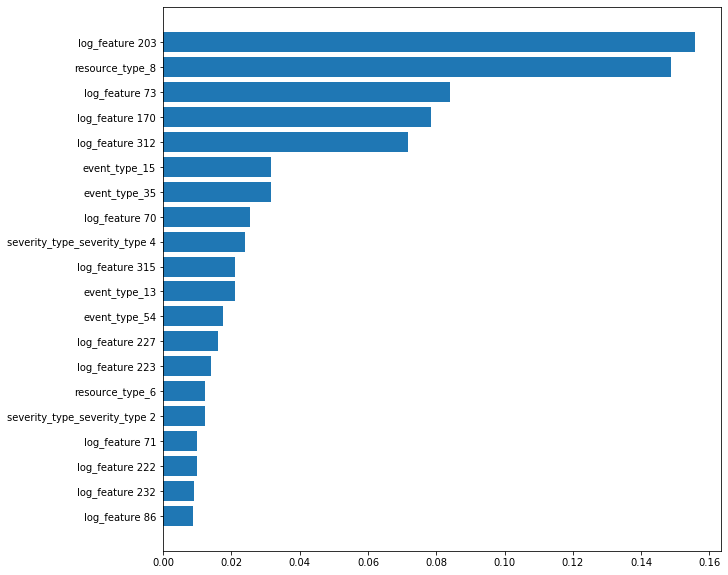

                           Feature    Weight
172                log_feature 203  0.155663
449                resource_type_8  0.148726
413                 log_feature 73  0.084104
135                log_feature 170  0.078556
293                log_feature 312  0.071602
9                    event_type_15  0.031549
30                   event_type_35  0.031494
410                 log_feature 70  0.025453
2    severity_type_severity_type 4  0.024079
296                log_feature 315  0.020986
7                    event_type_13  0.020978
51                   event_type_54  0.017590
198                log_feature 227  0.016048
194                log_feature 223  0.014102
447                resource_type_6  0.012179
0    severity_type_severity_type 2  0.012109
411                 log_feature 71  0.009970
193                log_feature 222  0.009754
204                log_feature 232  0.008883
427                 log_feature 86  0.008622


In [62]:
SeverityLevel1Model = ModelScores_List[ModelScores_List["F1"] == ModelScores_List["F1"].max()]["Name"].iloc[0]
SeverityLevel1Model = ModelParameters_List[ModelParameters_List["Name"] == "GradientBoostingClassifier"]["ModelData"].iloc[0]

ShowImportantFeatures(SeverityLevel1Model, 20)

In [63]:
SeverityLevel2TrainingData = CleanedData[(CleanedData["fault_severity"] == 0) | (CleanedData["fault_severity"] == 2)]
SeverityLevel2TrainingData["fault_severity"] = SeverityLevel2TrainingData["fault_severity"].replace(2, 1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
SeverityLevel2TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 5 to 18550
Columns: 452 entries, fault_severity to resource_type_9
dtypes: uint8(452)
memory usage: 2.4 MB


In [65]:
x_train, x_test, y_train, y_test = train_test_split(SeverityLevel2TrainingData.drop("fault_severity", axis = 1), SeverityLevel2TrainingData["fault_severity"], test_size = 0.2, random_state = 13)

ModelScores_List, ModelParameters_List = AssessClassifierModels(x_train, y_train, x_test, y_test, [GaussianNB, BernoulliNB, KNeighborsClassifier, DecisionTreeClassifier, GradientBoostingClassifier])
print(ModelScores_List)

                         Name  Accuracy  Precision    Recall        F1
4  GradientBoostingClassifier  0.941924   0.783784  0.783784  0.783784
2        KNeighborsClassifier  0.925590   0.753846  0.662162  0.705036
3      DecisionTreeClassifier  0.918330   0.716418  0.648649  0.680851
1                 BernoulliNB  0.807623   0.408046  0.959459  0.572581
0                  GaussianNB  0.660617   0.277559  0.952703  0.429878


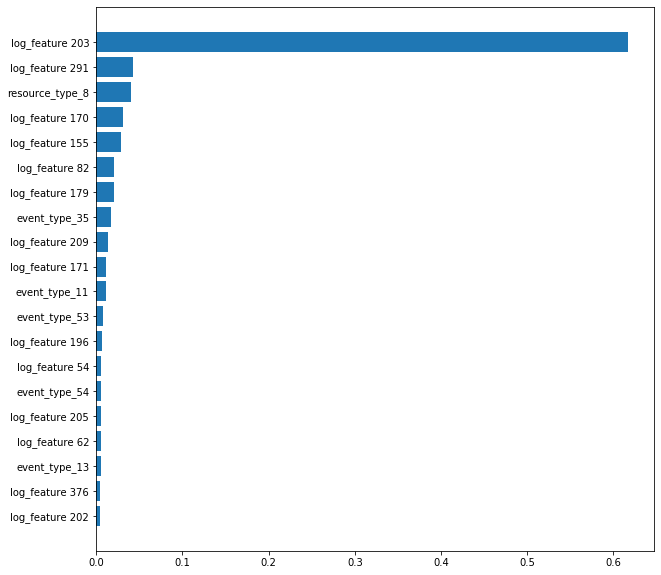

             Feature    Weight
172  log_feature 203  0.616580
269  log_feature 291  0.042673
449  resource_type_8  0.040012
135  log_feature 170  0.030740
118  log_feature 155  0.028471
423   log_feature 82  0.020739
144  log_feature 179  0.020379
30     event_type_35  0.017684
178  log_feature 209  0.013193
136  log_feature 171  0.011668
5      event_type_11  0.011538
50     event_type_53  0.007526
163  log_feature 196  0.006672
392   log_feature 54  0.006003
51     event_type_54  0.005926
174  log_feature 205  0.005219
401   log_feature 62  0.005086
7      event_type_13  0.005080
363  log_feature 376  0.004789
171  log_feature 202  0.004561


In [66]:
SeverityLevel2Model = ModelScores_List[ModelScores_List["F1"] == ModelScores_List["F1"].max()]["Name"].iloc[0]
SeverityLevel2Model = ModelParameters_List[ModelParameters_List["Name"] == "GradientBoostingClassifier"]["ModelData"].iloc[0]

ShowImportantFeatures(SeverityLevel2Model, 20)

## Predict fault_severity on other data

In [67]:
PredictionData = TrainingData[TrainingData["fault_severity"].isnull()]

In [68]:
PredictionData.isnull().sum().sort_values()

log_feature 250        0
log_feature 325        0
log_feature 324        0
log_feature 323        0
log_feature 322        0
                   ...  
log_feature 178        0
log_feature 177        0
log_feature 176        0
log_feature 2          0
fault_severity     11171
Length: 452, dtype: int64

In [69]:
PredictionResults = SeverityLevel1Model.predict(TrainingData.drop("fault_severity", axis = 1))

In [70]:
UniqueValues, UniqueCounts = np.unique(PredictionResults, return_counts = True)
print(np.asarray((UniqueValues, UniqueCounts)).T)

[[    0 15279]
 [    1  3273]]


In [71]:
PredictedData = TrainingData.drop("fault_severity", axis = 1).assign(FaultSeverityLevel1 = PredictionResults)

In [72]:
PredictionResults = SeverityLevel2Model.predict(TrainingData.drop("fault_severity", axis = 1))

In [73]:
UniqueValues, UniqueCounts = np.unique(PredictionResults, return_counts = True)
print(np.asarray((UniqueValues, UniqueCounts)).T)

[[    0 16234]
 [    1  2318]]


In [74]:
PredictedData = PredictedData.assign(FaultSeverityLevel2 = PredictionResults)

In [75]:
PredictedData[["FaultSeverityLevel1", "FaultSeverityLevel2"]]

,FaultSeverityLevel1,FaultSeverityLevel2
id,,
1,1,0
2,0,0
3,0,0
4,0,0
5,0,0
...,...,...
18548,0,0
18549,0,0
18550,0,0
